In [1]:
# Load packages:
import os
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
from collections import Counter
import pyproj
from datetime import datetime

In [2]:
# Define folder and path for intermediate and final datasets:
if(not os.path.isdir("Final_dataset")):
    os.mkdir("Final_dataset")
path_final = 'Final_dataset'

if(not os.path.isdir("Workset_dataset")):
    os.mkdir("Workset_dataset")
path_workset = 'Workset_dataset'

In [3]:
# define a single function which do both copy and preserve dtypes of each variable:
def copy_df(original_df):
    new_df = original_df.copy()
    new_df = new_df.astype(original_df.dtypes)
    return new_df

# Data preprocessing and Data cleaning

### Table of content
1) Loading dataset
    * Typing error
    * Load dataset

2) Data preprocessing
    * Timestamp conversion
    * "Type" variable creation
    * "Complete code" variable creation
    * Latitude and Longitude conversion
    * "Color" and "Criticality" derivation
    * Addition of other values for Type variable

3) Data cleaning
    * Subset observations up to a specific timestamp
    * Filter the dataset based on Group != 7
    * Filter the dataset based on Depot = 0
    * Filter the dataset based on Event = ON
    * Filter the dataset based on Monitor = MD
    * Filter the dataset based on Type = PDO
    * Detect and delete duplicates caused by obs with Type = trainset
    * Detect and delete duplicates caused by Monitor variable
    * Check "fake" alerts
    * Cope with "Blocco Permanente" e "Blocco Temporaneo" alerts
    * Cope with PDM without any PDO associated
    * Check and drop duplicates in the entire dataset

#### Typing error

Firstly, we need to solve issues caused by typo errors and format not recognised. Indeed, what has been noticed in the csv file is:
- inside the "depot" column there are commas instead of "|" which causes a shift of every values that follow the comma and, likewise, the creation of an additional fake column where the last value will be recorder
- inside the "master" column there are values different from what should be inside that column, so there are data entry errors

To figure out these errors, the csv file has been loaded as a text, typo errors and data entry errors have been replaced with the correct values and, lastly, the text file has been converted to a csv

In [4]:
# Read as text file:
input_file = 'TSR_040.csv'
with open('..//csv_dataset_TSR//'+input_file) as file:
    content = file.readlines()
#content


#   1) Solve issues caused by "depot" column --> we need to remove the comma because it causes a shift of values to additional fake columns:
'''
print(",R mistakes:")
for line in content:
    if ',R' in line:
        print(line)
print("\n")
'''

count = 0
for line in content:
    if ',R' in line:
        count += 1
print(f"The substring ',R' occurs {count} times")       # =49 times
        
for i, line in enumerate(content):
    if ',R' in line:
         content[i] = line.replace(',R', '|R')


#   2) Check mistakes for "master" column:
print("\n")
print("Mistakes in master column:")
#   -'        ssen\x18 '
for line in content:
    if '        ssen\x18 '  in line:
        print(line)
        
#   -'\x07 \x19   \x07'
for line in content:
    if '\x07 \x19   \x07' in line:
        print(line)
        
#   -'5Ap Emerg Porta '
for line in content:
    if '5Ap Emerg Porta ' in line:
        print(line)
        
# just 3 cases and they don't cause any shift, they are just typed where they shouldn't be --> remove them:
for i, line in enumerate(content):
    if '        ssen\x18 ' in line:
        content[i] = line.replace('        ssen\x18 ', '')
    if '\x07 \x19   \x07' in line:
        content[i] = line.replace('\x07 \x19   \x07', '')
    if '5Ap Emerg Porta ' in line:
        content[i] = line.replace('5Ap Emerg Porta ', '')


# Replace this modified contents into the original file:
with open(path_workset+'//modified_'+input_file, 'w') as file:
    file.writelines(content)

The substring ',R' occurs 49 times


Mistakes in master column:
711-084,711-083,MD,PDM,1611057435000,7,11,0,ON,        ssen ,,0,45.6656,9.13472,,1

711-084,711-084,MS,PDM,1612797378000,7,30,0,OFF,    ,,0,45.5789,9.15668,,0

711-084,,MD,PDM,1612873014000,7,11,0,ON,5Ap Emerg Porta ,,0,45.75,9.13418,,0



#### Load dataset
The modified csv has been loaded and columns that are not necessary for the analysis have been removed

In [5]:
# Load the dataset and rename columns:
data = pd.read_csv(path_workset+'//modified_'+input_file, delimiter=',', dtype={
    'Sorgente_Dati': 'category',
    'Vettura': 'category',
    'Monitor': 'category',
    'Tipo': 'category',
    'Evento': 'category',
    'Master': 'category',
    'Deposito': 'category'
})
data = data.rename(columns={'Sorgente_Dati': 'source',
                            'Vettura': 'name',
                            'Monitor': 'machine_type',
                            'Tipo': 'alert_type',
                            'Unix_timestamp(ms)': 'ts',
                            'Gruppo': 'cod',
                            'PdM': 'id',
                            'PdO': 'id1',
                            'Evento': 'event_type',
                            'Master': 'master',
                            'Pantografo': 'pantograph',
                            'Velocità': 'speed',
                            'Latitudine': 'lat',
                            'Longitudine': 'lon',
                            'extra': 'extra',
                            'Deposito': 'depot'
                            })

# check data:
print(data.head())

    source     name machine_type alert_type             ts  cod  id  id1  \
0  711-083  710-170           MD        PDM  1604725173000    5  15    0   
1  711-083  711-083           MD        PDM  1604726631000    5   8    0   
2  711-083  711-083           MD        PDM  1604726633000    5   8    0   
3  711-083  710-170           MD        PDM  1604727811000    5  15    0   
4  711-083  710-170           MD        PDM  1604727812000    5  15    0   

  event_type          master  pantograph  speed      lat      lon extra depot  
0         ON  Master Assente         NaN     22  45.6522  9.13974   NaN     0  
1         ON  Master Assente         NaN      4  45.5334  9.17278   NaN     0  
2        OFF  Master Assente         NaN     10  45.5333  9.17278   NaN     0  
3        OFF  Master Assente         NaN      0  45.4695  9.17390   NaN     0  
4         ON  Master Assente         NaN      0  45.4695  9.17390   NaN     0  


In [6]:
# Drop columns not of interest:
data.info()
df = data.drop(columns=['pantograph','extra'])
print("\n")
df.info()   # 1892948 entries and 14 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892948 entries, 0 to 1892947
Data columns (total 16 columns):
 #   Column        Dtype   
---  ------        -----   
 0   source        category
 1   name          category
 2   machine_type  category
 3   alert_type    category
 4   ts            int64   
 5   cod           int64   
 6   id            int64   
 7   id1           int64   
 8   event_type    category
 9   master        category
 10  pantograph    float64 
 11  speed         int64   
 12  lat           float64 
 13  lon           float64 
 14  extra         object  
 15  depot         category
dtypes: category(7), float64(3), int64(5), object(1)
memory usage: 142.6+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892948 entries, 0 to 1892947
Data columns (total 14 columns):
 #   Column        Dtype   
---  ------        -----   
 0   source        category
 1   name          category
 2   machine_type  category
 3   alert_type    category
 4   ts            int6

#### Timestamp conversion
The format of "ts" column is milliseconds, which is 1/1000 seconds, therefore a conversion from unix timestamp to datetime is needed. Subsequently, the dataset has been ordered according to the timestamp, as recommended from Trenord

(source: "readme" file)

In [7]:
# Change the timestamp format:
df['ts_UTC'] = pd.to_datetime(df['ts'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Europe/Rome')
df['Time']  = df['ts_UTC'].dt.floor('s',ambiguous=False).dt.tz_localize(None,ambiguous=False)
df = df.drop(columns=['ts_UTC'])
print(df.head())

# we don't need it anymore:
df1 = df.drop(columns='ts')

    source     name machine_type alert_type             ts  cod  id  id1  \
0  711-083  710-170           MD        PDM  1604725173000    5  15    0   
1  711-083  711-083           MD        PDM  1604726631000    5   8    0   
2  711-083  711-083           MD        PDM  1604726633000    5   8    0   
3  711-083  710-170           MD        PDM  1604727811000    5  15    0   
4  711-083  710-170           MD        PDM  1604727812000    5  15    0   

  event_type          master  speed      lat      lon depot  \
0         ON  Master Assente     22  45.6522  9.13974     0   
1         ON  Master Assente      4  45.5334  9.17278     0   
2        OFF  Master Assente     10  45.5333  9.17278     0   
3        OFF  Master Assente      0  45.4695  9.17390     0   
4         ON  Master Assente      0  45.4695  9.17390     0   

                 Time  
0 2020-11-07 05:59:33  
1 2020-11-07 06:23:51  
2 2020-11-07 06:23:53  
3 2020-11-07 06:43:31  
4 2020-11-07 06:43:32  


In [8]:
'''
# str format in order to see the milliseconds:
from datetime import datetime
str_time = []
for x in data['ts']:
    time = datetime.fromtimestamp(x/1000.00).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    str_time.append(time)

print(str_time[0:100])      #penso non ci sia mai il millisecond perchè le ultime 3 cifre sono sempre 0

print("\n")
prova = datetime.fromtimestamp(1604725173.3748)
print("prova data con millisecondi:")
print(prova)
'''

'\n# str format in order to see the milliseconds:\nfrom datetime import datetime\nstr_time = []\nfor x in data[\'ts\']:\n    time = datetime.fromtimestamp(x/1000.00).strftime(\'%Y-%m-%d %H:%M:%S.%f\')[:-3]\n    str_time.append(time)\n\nprint(str_time[0:100])      #penso non ci sia mai il millisecond perchè le ultime 3 cifre sono sempre 0\n\nprint("\n")\nprova = datetime.fromtimestamp(1604725173.3748)\nprint("prova data con millisecondi:")\nprint(prova)\n'

In [9]:
# Order the dataset according to the timestamp:
df2 = df1.sort_values(by='Time')
df2 = df2.reset_index(drop=True)
df2.info()
print("\n")
print(df2.head())  # first obs: 2020-11-07 05:59:33
print("\n")
print(df2.tail())  # last obs: 2024-05-21 21:28:22

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892948 entries, 0 to 1892947
Data columns (total 14 columns):
 #   Column        Dtype         
---  ------        -----         
 0   source        category      
 1   name          category      
 2   machine_type  category      
 3   alert_type    category      
 4   cod           int64         
 5   id            int64         
 6   id1           int64         
 7   event_type    category      
 8   master        category      
 9   speed         int64         
 10  lat           float64       
 11  lon           float64       
 12  depot         category      
 13  Time          datetime64[ns]
dtypes: category(7), datetime64[ns](1), float64(2), int64(4)
memory usage: 113.7 MB


    source     name machine_type alert_type  cod  id  id1 event_type  \
0  711-083  710-170           MD        PDM    5  15    0         ON   
1  711-083  711-083           MD        PDM    5   8    0         ON   
2  711-083  711-083           MD        P

#### Subset observations up to a specific timestamp
(source: fermo treno dal 2023/09/27 al 2024/01/25)

In [10]:
# Keep obs until 2023-09-28:
df3 = df2[df2['Time'] <= '2023-09-28']
print(df3.tail())   # last obs 2023-09-27 23:08:54
print("\n")
df3.info()          # 1772148 entries

          source     name machine_type alert_type  cod  id  id1 event_type  \
1772143  711-084  711-084           MD        PDO    5  98   10         ON   
1772144  711-084  711-084           MD        PDO    7  40    1        OFF   
1772145  711-084  711-084           MD        PDM    7  40    0        OFF   
1772146  711-084  711-084           MD        PDM    7  40    0         ON   
1772147  711-084  711-084           MD        PDO    7  40    1         ON   

                 master  speed      lat      lon depot                Time  
1772143         711-084      0  45.4683  9.17528     0 2023-09-27 22:25:50  
1772144  Master Assente      0  45.5325  9.13279     0 2023-09-27 23:07:26  
1772145  Master Assente      0  45.5325  9.13279     0 2023-09-27 23:07:26  
1772146         711-084      0  45.5325  9.13279     0 2023-09-27 23:08:54  
1772147         711-084      0  45.5325  9.13279     0 2023-09-27 23:08:54  


<class 'pandas.core.frame.DataFrame'>
Index: 1772148 entries, 0 to 

In [11]:
# Quick check at each variable to assess their values:
column_to_check= ['source', 'name', 'machine_type', 'alert_type', 'cod', 'id', 'id1', 'event_type', 'master', 'speed', 'depot']

for i in column_to_check:
    unique_values_i = df3[i].unique()
    print(f"Unique values of {i}:", unique_values_i)
    print("\n")

# results:
#   -nan in "name", "event_type" and "master" --> only for PDM and/or trainset obs, so no probl (csv check)
#   -in "name" there are 7 wagon names but TSR040 is made up of 6 wagons --> 710-000 appears only for trainset obs, so no probl (csv check)

Unique values of source: ['711-083', '711-084']
Categories (2, object): ['711-083', '711-084']


Unique values of name: ['710-170', '711-083', '710-131', '710-135', '711-084', '710-132', NaN, '710-000']
Categories (7, object): ['710-131', '710-132', '710-135', '710-170', '711-083', '711-084', '710-000']


Unique values of machine_type: ['MD', 'MS']
Categories (2, object): ['MD', 'MS']


Unique values of alert_type: ['PDM', 'PDO', 'TrainSet']
Categories (3, object): ['PDM', 'PDO', 'TrainSet']


Unique values of cod: [5 7 2 0]


Unique values of id: [15  8  9  4 16  3 12 43  2  1 30 13 14 31 72 81 82  5 98 71 26 25 24 11
 94 10 92 35 40 22 17  6 83 73 33 21 23 42  7 74 39 99 32 28 19 20 45 36
 34 37 29 18 91 41 93 27 84 38 90  0]


Unique values of id1: [ 0  5 15 13 14  1 18 17 10  2  4  3  6 12 11  9 16  7  8 31 29 28 23 22
 30 19 27 20 21 24 25 32 33 44 34 41 43 42 26]


Unique values of event_type: ['ON', 'OFF', NaN]
Categories (2, object): ['OFF', 'ON']


Unique values of master: ['M

#### Filter the dataset based on Group != 7
The focus of the analysis is on the Traction Control Unit (TCU) which corresponds to group=5. There are also correlated alerts, which belong to group=2, and alerts about the Door System, which are part of group=7. Then, observation with group=7 are filtered out

#### Filter the dataset based on Depot = 0
Log data include both alerts generated during the route and generated specifically in the depot when the maintenance takes place. Since the analysis seek for alerts that can occur during the service, it is necessary to filtered out the depot's ones

In [12]:
# Filter the dataset according to "cod" and "depot":
df4 = copy_df(df3)
df4 = df4[df4['cod'] != 7]
df4.reset_index(drop=True, inplace=True)
df4 = df4[df4['depot'] == '0']
df4.reset_index(drop=True, inplace=True)
print(df4.info())   # length: 1080207 (from 1772148)
print("\n")

# check:
filters = ['event_type', 'depot', 'cod']
for i in filters:
    sum_by_group = df4.groupby(i, dropna=False).size()
    print("Summary of:", i)
    print(sum_by_group)
    print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080207 entries, 0 to 1080206
Data columns (total 14 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   source        1080207 non-null  category      
 1   name          1036277 non-null  category      
 2   machine_type  1080207 non-null  category      
 3   alert_type    1080207 non-null  category      
 4   cod           1080207 non-null  int64         
 5   id            1080207 non-null  int64         
 6   id1           1080207 non-null  int64         
 7   event_type    1077574 non-null  category      
 8   master        1036277 non-null  category      
 9   speed         1080207 non-null  int64         
 10  lat           1080207 non-null  float64       
 11  lon           1080207 non-null  float64       
 12  depot         1080207 non-null  category      
 13  Time          1080207 non-null  datetime64[ns]
dtypes: category(7), datetime64[ns](1), float64(2), int

/tmp/ipykernel_2864487/3586810676.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_group = df4.groupby(i, dropna=False).size()
/tmp/ipykernel_2864487/3586810676.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_group = df4.groupby(i, dropna=False).size()


#### Cope with PDM without any PDO associated
PDM 5-17 doesn't have any associated PDO because it isn't detected by the TCU since, actually, it is not an alert. PDM 5-17 is "Esclusione frenatura elettrica" which is something that the train drivers manually and autonomously activate in the monitor based on what is happening regarding all the alerts occured. Hence, PDM 5-17 has to be considered as something else than an alert

(source: videocall 10/05 and 12/07)

In [13]:
# Check frequency of PDM 5-17:
freq_5_17 = ((df4['cod'] == 5) & (df4['id'] == 17) & (df4['id1'] == 0)).sum()
print(f"Frequency of PDM 5-17 is:", freq_5_17)  # =737
print("\n")

print("5-17-0 --> 'pdm'")
count_pdm_17 = ((df4['cod'] == 5) & (df4['id'] == 17) & (df4['id1'] == 0)).sum()
print(f"Number of rows where cod=5, id=17, id1=0:", count_pdm_17)
print("\n")

print("5-17-0 and pdm")
count_pdm_17 = ((df4['cod'] == 5) & (df4['id'] == 17) & (df4['id1'] == 0) & (df4['alert_type'] == 'PDM')).sum()
print(f"Number of rows where cod=5, id=17, id1=0 and alert_type=PDM:", count_pdm_17)
print("\n")

print("5-17 and pdo")
count_pdo_17 = ((df4['cod'] == 5) & (df4['id'] == 17) & (df4['alert_type'] == 'PDO')).sum()
print(f"Number of rows where cod=5, id=17 and alert_type=PDO:", count_pdo_17)

# results:
# pdm 5-17 has no pdo associated!

Frequency of PDM 5-17 is: 737


5-17-0 --> 'pdm'
Number of rows where cod=5, id=17, id1=0: 737


5-17-0 and pdm
Number of rows where cod=5, id=17, id1=0 and alert_type=PDM: 737


5-17 and pdo
Number of rows where cod=5, id=17 and alert_type=PDO: 0


In [14]:
# Check values of source, name, speed of these obs:
df_5_17 = df4[(df4['cod'] == 5) & (df4['id'] == 17)]
print(df_5_17)
print("\n")

filters = ['source', 'name', 'machine_type', 'event_type', 'speed']
for i in filters:
    sum_by_group = df_5_17.groupby(i, dropna=False).size()
    print("Summary of:", i)
    print(sum_by_group)
    print("\n")

          source     name machine_type alert_type  cod  id  id1 event_type  \
1364     711-084  710-170           MS        PDM    5  17    0         ON   
1672     711-084  711-084           MS        PDM    5  17    0         ON   
2606     711-084  710-132           MS        PDM    5  17    0         ON   
2607     711-084  710-132           MS        PDM    5  17    0        OFF   
3035     711-084  710-132           MS        PDM    5  17    0         ON   
...          ...      ...          ...        ...  ...  ..  ...        ...   
1052184  711-083  710-131           MD        PDM    5  17    0         ON   
1052188  711-084  710-131           MS        PDM    5  17    0         ON   
1052190  711-084  710-131           MD        PDM    5  17    0         ON   
1076216  711-083  710-131           MD        PDM    5  17    0         ON   
1076217  711-083  710-131           MD        PDM    5  17    0        OFF   

                 master  speed      lat      lon depot         

/tmp/ipykernel_2864487/253077756.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_group = df_5_17.groupby(i, dropna=False).size()
/tmp/ipykernel_2864487/253077756.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_group = df_5_17.groupby(i, dropna=False).size()
/tmp/ipykernel_2864487/253077756.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_group = df_5_17.groupby(i, dropna=False).size()
/tmp

In [15]:
# In order to keep this info, I convert it into a pdo in order to NOT loose it. Then, in the end, I'll add a second value for "type" variable for these obs:
for i in range(len(df4)):
    if df4.loc[i, 'cod'] == 5 and df4.loc[i, 'id'] == 17:
        df4.loc[i, 'id1'] = 1
        df4.loc[i, 'alert_type'] = 'PDO'

#PER L'OTTIMIZZAZIONE: qua non penso si possa fare con l'apply lambda e comnunque ci sta 15 sec tipo

# check:
count_pdo_17 = ((df4['cod'] == 5) & (df4['id'] == 17) & (df4['id1'] == 1)).sum()
print(count_pdo_17)

737


#### Check "fake" alerts
PDM 5-31,5-32,5-33,5-34,5-35,5-36,5-90,5-98,5-99 are artificial because they have been created in order to be inspected by the operator who support remotely the train driver, otherwise they would never appear since there isn't any logical link between them and all the PDO. This means that all these PDO haven't the corrisponding PDM. Additionally, there are 3 PDO with id1=0 but alert_type=PDO and for these cases the code has been changed to 99

(source: videocall 10/05 and 12/07)

In [16]:
contingency_table2_a = pd.crosstab(df4['alert_type'], df4['id1'], margins=True, margins_name='Total')
print(contingency_table2_a.iloc[:, :6])

id1              0       1      2      3     4     5
alert_type                                          
PDM         481415   50581    186    104    90     0
PDO          12173  301325  21859   9992  9346  4336
TrainSet     43930       0      0      0     0     0
Total       537518  351906  22045  10096  9436  4336


In [17]:
# 1) Check all of them:
fake_pdm = [31,32,33,34,35,36,90,98,99]

#   a) 5-i-0 ("pdm"):
print("5-i-0 --> 'pdm'")
for i in fake_pdm:
    count_fake_pdm_i = ((df4['cod'] == 5) & (df4['id'] == i) & (df4['id1'] == 0)).sum()
    print(f"Number of rows where cod=5, id={i} and id1=0:", count_fake_pdm_i)
    #print("\n")
    #filtered_df_i = df3[df3['id'] == i]
    #print(f"Observations where PDM = {i} :", filtered_df_i)
    #print("\n")
print("\n")

#   b) 5-i-0 and PDM (true pdm):
print("5-i-0 and pdm")
for i in fake_pdm:
    count_fake_pdm_i = ((df4['cod'] == 5) & (df4['id'] == i) & (df4['id1'] == 0) & (df4['alert_type'] == 'PDM')).sum()
    print(f"Number of rows where cod=5, id={i}, id1=0 and alert_type=PDM:", count_fake_pdm_i)
print("\n")    
    
#   c) 5-i and pdo (true pdo):
print("5-i and pdo")
for i in fake_pdm:
    count_fake_pdo_i = ((df4['cod'] == 5) & (df4['id'] == i) & (df4['alert_type'] == 'PDO')).sum()
    print(f"Number of rows where cod=5, id={i} and alert_type=PDO:", count_fake_pdo_i)
print("\n")

#   d) 5-i-0 and pdo (fake pdm):
print("5-i-0 and pdo")
for i in fake_pdm:
    count_fake_pdo_i = ((df4['cod'] == 5) & (df4['id'] == i) & (df4['id1'] == 0) & (df4['alert_type'] == 'PDO')).sum()
    print(f"Number of rows where cod=5, id={i}, id1=0 and alert_type=PDO:", count_fake_pdo_i)
print("\n")


'''
# group=2:
print("\n")
print("idem but for group 2")
for i in fake_pdm:
    count_fake_pdm_i = ((df3['id'] == i) & (df3['cod'] == 2) & (df3['id1'] == 0)).sum()
    print(f"Number of rows where cod=2, id={i} and id1=0:", count_fake_pdm_i)
print("\n")

for i in fake_pdm:
    count_fake_pdm_i = ((df3['id'] == i) & (df3['cod'] == 2) & (df3['id1'] == 0) & (df3['alert_type'] == 'PDM')).sum()
    print(f"Number of rows where cod=2, id={i}, id1=0 and alert_type=PDM:", count_fake_pdm_i)
print("\n")

for i in fake_pdm:
    count_fake_pdo_i = ((df3['id'] == i) & (df3['cod'] == 2) & (df3['alert_type'] == 'PDO')).sum()
    print(f"Number of rows where cod=2, id={i} and alert_type=PDO:", count_fake_pdo_i)
print("\n")
'''

'''
# deeper check:
col_name = ['machine_type', 'alert_type', 'event_type', 'master', 'depot']
for i in fake_pdm:
    for k in col_name:
        filtered_df_i = df3[df3['id'] == i]
        print(f"Values for PDM {i} and column:")
        print(filtered_df_i[k].value_counts())
        print("\n")
'''


# 2) Change id1 code from 0 to 99 for PDO 34,35,36:
df4['id1'] = df4.apply(lambda row: 99 if row['id'] == 34 and row['alert_type'] == 'PDO' and row['id1'] == 0 else row['id1'], axis=1)
df4['id1'] = df4.apply(lambda row: 99 if row['id'] == 35 and row['alert_type'] == 'PDO' and row['id1'] == 0 else row['id1'], axis=1)
df4['id1'] = df4.apply(lambda row: 99 if row['id'] == 36 and row['alert_type'] == 'PDO' and row['id1'] == 0 else row['id1'], axis=1)


# check:
print("5-i-0 and pdo")
for i in fake_pdm:
    count_fake_pdo_i = ((df4['cod'] == 5) & (df4['id'] == i) & (df4['id1'] == 0) & (df4['alert_type'] == 'PDO')).sum()
    print(f"Number of rows where cod=5, id={i}, id1=0 and alert_type=PDO:", count_fake_pdo_i)
print("\n")

5-i-0 --> 'pdm'
Number of rows where cod=5, id=31 and id1=0: 0
Number of rows where cod=5, id=32 and id1=0: 0
Number of rows where cod=5, id=33 and id1=0: 0
Number of rows where cod=5, id=34 and id1=0: 58
Number of rows where cod=5, id=35 and id1=0: 71
Number of rows where cod=5, id=36 and id1=0: 180
Number of rows where cod=5, id=90 and id1=0: 0
Number of rows where cod=5, id=98 and id1=0: 0
Number of rows where cod=5, id=99 and id1=0: 0


5-i-0 and pdm
Number of rows where cod=5, id=31, id1=0 and alert_type=PDM: 0
Number of rows where cod=5, id=32, id1=0 and alert_type=PDM: 0
Number of rows where cod=5, id=33, id1=0 and alert_type=PDM: 0
Number of rows where cod=5, id=34, id1=0 and alert_type=PDM: 0
Number of rows where cod=5, id=35, id1=0 and alert_type=PDM: 0
Number of rows where cod=5, id=36, id1=0 and alert_type=PDM: 0
Number of rows where cod=5, id=90, id1=0 and alert_type=PDM: 0
Number of rows where cod=5, id=98, id1=0 and alert_type=PDM: 0
Number of rows where cod=5, id=99, id

#### Cope with "Blocco Permanente" and "Blocco temporaneo" alerts
There are 4 PDM named "Blocco permanente ***", which are: 5-3, 5-5, 5-7, 5-9.
Each of them has a PDO with the same name and id1=00, and this causes some troubles for the analysis.
Additionally, only the related PDO 00 generates the PDM associated to it, which is that any of the others PDO don't generate the corresponding PDM.
Among these PDO, there is a "Blocco temporaneo ***" which is significant, therefore, in order to generate the PDM associated to these PDO, artificial PDM have been created and they have been named exaclty "Blocco temporaneo ***". Also this aspect is a source of troubles for the analysis.
To conclude, it is necessary to:
1) check all these PDM and PDO
2) change the code of PDO 00
3) drop the artificial PDM and keep only the PDO

(source: file "Codici diagnostici TCU critici.xlsx" and mail 24/05)

1) Check all of them

Recap:
- PDM "Blocco permanente ***" 5-3, 5-5, 5-7, 5-9 --> focus on them!
- PDO "Blocco permanente ***" 5-3-00, 5-5-00, 5-7-00, 5-9-00 --> id1=0 and not 00, so they seem to be PDM but the column "type" is able to define them correctly
- PDM "Blocco temporaneo ***" 5-2, 5-4, 5-6, 5-8 --> they are generated from the PDO with code 01 of the PDM "Blocco permanente ***"

In [18]:
pdm_bl_perm = [3,5,7,9]
pdm_bl_temp = [2,4,6,8]

# a) 5-i-0 ("pdm blocco permanente"):
print("5-i-0 --> 'pdm' blocco permanente ***")
for i in pdm_bl_perm:
    count_pdm_bl_perm_i = ((df4['cod'] == 5) & (df4['id'] == i) & (df4['id1'] == 0)).sum()
    print(f"Number of rows where cod=5, id={i} and id1=0:", count_pdm_bl_perm_i)
    #print("\n")
    #filtered_df_i = df3[df3['id'] == i]
    #print(f"Observations where PDM = {i} :", filtered_df_i)
    #print("\n")
print("\n")

# b) 5-i-0 and PDM (true pdm):
print("5-i-0 and pdm")
for i in pdm_bl_perm:
    count_pdm_bl_perm_i = ((df4['cod'] == 5) & (df4['id'] ==i) & (df4['id1'] == 0) & (df4['alert_type'] == 'PDM')).sum()
    print(f"Number of rows where cod=5, id={i}, id1=0 and alert_type=PDM:", count_pdm_bl_perm_i)
print("\n")    
    
# c) 5-i and pdo (true pdo):
print("5-i and pdo")
for i in pdm_bl_perm:
    count_pdo_bl_perm_i = ((df4['cod'] == 5) & (df4['id'] == i) & (df4['alert_type'] == 'PDO')).sum()
    print(f"Number of rows where cod=5, id={i} and alert_type=PDO:", count_pdo_bl_perm_i)
print("\n")

# d) 5-i-0 and pdo (fake pdm):
print("5-i-0 and pdo")
for i in pdm_bl_perm:
    count_pdo_bl_perm_i = ((df4['cod'] == 5) & (df4['id'] == i) & (df4['id1'] == 0) & (df4['alert_type'] == 'PDO')).sum()
    print(f"Number of rows where cod=5, id={i}, id1=0 and alert_type=PDO:", count_pdo_bl_perm_i)
print("\n")

# e) 5-k-0 ("pdm blocco temporaneo"):
print("5-k-0 --> 'pdm' blocco temporaneo ***")
for k in pdm_bl_temp:
    count_pdm_bl_temp_k = ((df4['cod'] == 5) & (df4['id'] == k) & (df4['id1'] == 0)).sum()
    print(f"Number of rows where cod=5, id={k} and id1=0:", count_pdm_bl_temp_k)
print("\n")

# f) 5-k-0 and PDM (true pdm):
print("5-k-0 and pdm")
for k in pdm_bl_temp:
    count_pdm_bl_temp_k = ((df4['cod'] == 5) & (df4['id'] ==k) & (df4['id1'] == 0) & (df4['alert_type'] == 'PDM')).sum()
    print(f"Number of rows where cod=5, id={k}, id1=0 and alert_type=PDM:", count_pdm_bl_temp_k)
print("\n")

# g) 5-k and pdo (true pdo):
print("5-k and pdo")
for k in pdm_bl_temp:
    count_pdo_bl_temp_k = ((df4['cod'] == 5) & (df4['id'] == k) & (df4['alert_type'] == 'PDO')).sum()
    print(f"Number of rows where cod=5, id={k} and alert_type=PDO:", count_pdo_bl_temp_k)
print("\n")

5-i-0 --> 'pdm' blocco permanente ***
Number of rows where cod=5, id=3 and id1=0: 11113
Number of rows where cod=5, id=5 and id1=0: 4553
Number of rows where cod=5, id=7 and id1=0: 505
Number of rows where cod=5, id=9 and id1=0: 27611


5-i-0 and pdm
Number of rows where cod=5, id=3, id1=0 and alert_type=PDM: 7643
Number of rows where cod=5, id=5, id1=0 and alert_type=PDM: 3148
Number of rows where cod=5, id=7, id1=0 and alert_type=PDM: 319
Number of rows where cod=5, id=9, id1=0 and alert_type=PDM: 20808


5-i and pdo
Number of rows where cod=5, id=3 and alert_type=PDO: 24661
Number of rows where cod=5, id=5 and alert_type=PDO: 27812
Number of rows where cod=5, id=7 and alert_type=PDO: 9269
Number of rows where cod=5, id=9 and alert_type=PDO: 27322


5-i-0 and pdo
Number of rows where cod=5, id=3, id1=0 and alert_type=PDO: 3470
Number of rows where cod=5, id=5, id1=0 and alert_type=PDO: 1405
Number of rows where cod=5, id=7, id1=0 and alert_type=PDO: 186
Number of rows where cod=5, id

2) Identify and change codes of PDO 00 related to "Blocco permanente":

In [19]:
# Change from 0 to 99 for PDO00 Blocco permanente:
df4['id1'] = df4.apply(lambda row: 99 if row['alert_type'] == 'PDO' and row['id1'] == 0 else row['id1'], axis=1)


# check:
print("5-i-0 and pdo")
for i in pdm_bl_perm:
    count_pdo_bl_perm_i = ((df4['cod'] == 5) & (df4['id'] == i) & (df4['id1'] == 0) & (df4['alert_type'] == 'PDO')).sum()
    print(f"Number of rows where cod=5, id={i}, id1=0 and alert_type=PDO:", count_pdo_bl_perm_i)
print("\n")

5-i-0 and pdo
Number of rows where cod=5, id=3, id1=0 and alert_type=PDO: 0
Number of rows where cod=5, id=5, id1=0 and alert_type=PDO: 0
Number of rows where cod=5, id=7, id1=0 and alert_type=PDO: 0
Number of rows where cod=5, id=9, id1=0 and alert_type=PDO: 0




#### "Type" variable creation

Trenord has advised that the "alert_type" variable is not correct at all, because sometimes it assumes value "pdm" when actually the alert is a pdo, and viceversa. Indeed, a correct development of the variable has been done. Specifically, with respect to "alert_type", the new "Type" variable is:
- unaltered if "alert_type"=="PDO" and "id1"==0 --> some of this case have already been corrected by changing id1 from 0 to 99
- unaltered if "alert_type"=="TRAINSET"
- otherwise takes value "PDM" or "PDO" according to the value of "id1" --> because a PDM has id1=0 while a PDO has id1!=0 by definition

(source: "estratto requisiti telediagnostica" pag. 12 and mail 24/05)

In [20]:
df4['alert_type'] = df4['alert_type'].str.upper()
#df5['alert_type'] = df5['alert_type'].astype('category')


# quick check:
count_PDO00 = ((df4['alert_type'] == 'PDO') & (df4['id1'] == 0)).sum()
print("Number of rows where alert_type is 'PDO' and id1 is 0:", count_PDO00)  # =0


df4['Type'] = df4.apply(lambda row: 'TRAINSET' if row['alert_type'] == 'TRAINSET' else ('PDM' if row['id1'] == 0 else 'PDO'), axis=1)
df4['Type'] = df4['Type'].astype('category')


print("\n")
contingency_table2_b = pd.crosstab(df4['Type'], df4['id1'], margins=True, margins_name='Total')
print(contingency_table2_b.iloc[:, :6])

Number of rows where alert_type is 'PDO' and id1 is 0: 0


id1            0       1      2      3     4     5
Type                                              
PDM       481415       0      0      0     0     0
PDO            0  351906  22045  10096  9436  4336
TRAINSET   43930       0      0      0     0     0
Total     525345  351906  22045  10096  9436  4336


#### "Complete code" variable creation
A variable with the full code (cod-id-id1) has been derived

In [21]:
# "Complete code" variable:
df4['Complete_code'] = df4.apply(lambda row: f"{row['cod']}-{row['id']}" if row['id1'] == 0 else f"{row['cod']}-{row['id']}-{row['id1']}", axis=1)
df4['Complete_code'] = df4['Complete_code'].astype('category')
print(df4[:10])

# check:
contingency_table4 = pd.crosstab(df4['Type'], df4['Complete_code'], margins=True, margins_name='Total')
contingency_table4

    source     name machine_type alert_type  cod  id  id1 event_type  \
0  711-083  710-170           MD        PDM    5  15    0         ON   
1  711-083  711-083           MD        PDM    5   8    0         ON   
2  711-083  711-083           MD        PDM    5   8    0        OFF   
3  711-083  710-170           MD        PDM    5  15    0        OFF   
4  711-083  710-170           MD        PDM    5  15    0         ON   
5  711-083  710-131           MD        PDM    5  15    0         ON   
6  711-083  710-170           MD        PDM    5  15    0         ON   
7  711-083  710-170           MD        PDM    5  15    0         ON   
8  711-083  711-083           MD        PDM    5   8    0         ON   
9  711-083  711-083           MD        PDM    5   8    0        OFF   

           master  speed      lat      lon depot                Time Type  \
0  Master Assente     22  45.6522  9.13974     0 2020-11-07 05:59:33  PDM   
1  Master Assente      4  45.5334  9.17278     0 2020

Complete_code,0-0,2-1,2-1-1,2-10,2-11,2-12,2-13,2-14,2-15,2-16,...,5-99-11,5-99-12,5-99-13,5-99-14,5-99-5,5-99-6,5-99-7,5-99-8,5-99-9,Total
Type,,,,,,,,,,,,,,,,,,,,,
PDM,0,40,0,70,382,250,2726,4122,9701,579,...,0,0,0,0,0,0,0,0,0,481415
PDO,0,0,608,0,0,0,0,0,0,0,...,2658,286,1673,339,326,191,510,2075,1060,554862
TRAINSET,43930,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,43930
Total,43930,40,608,70,382,250,2726,4122,9701,579,...,2658,286,1673,339,326,191,510,2075,1060,1080207


3) Discard all the PDM "Blocco temporaneo ***":

In [22]:
# Check frequency of PDM 5-2,5-4,5-6,5-8 and PDO 5-3-1,5-5-1,5-7-1,5-9-1:
code = 5
subgrouppdm = [2,4,6,8]
subgrouppdo = [3,5,7,9]

for k in subgrouppdo:
    freq_pdo = ((df4['cod'] == code) & (df4['id'] == k) & (df4['id1'] == 1)).sum()
    print(f"Frequency of PDO {code}-{k}-1 is:", freq_pdo)
print("\n")
for j in subgrouppdm:
    freq_pdm = ((df4['cod'] == code) & (df4['id'] == j) & (df4['id1'] == 0)).sum()
    print(f"Frequency of PDM {code}-{j} is:", freq_pdm)

# results: pdm = 2*pdm more or less
# given the duplication of pdm caused by "master" and "trainset" I assume this twice is reasonable!


# Drop PDM 5-2,5-4,5-6,5-8:
df5 = df4[~df4['Complete_code'].isin(['5-2','5-4','5-6','5-8'])]
df5.reset_index(drop=True, inplace=True)
print("\n")
df5.info()  # length: 992681 (from 1080207)

Frequency of PDO 5-3-1 is: 7068
Frequency of PDO 5-5-1 is: 22842
Frequency of PDO 5-7-1 is: 4425
Frequency of PDO 5-9-1 is: 13828


Frequency of PDM 5-2 is: 14455
Frequency of PDM 5-4 is: 35949
Frequency of PDM 5-6 is: 8786
Frequency of PDM 5-8 is: 28336


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992681 entries, 0 to 992680
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   source         992681 non-null  category      
 1   name           948751 non-null  category      
 2   machine_type   992681 non-null  category      
 3   alert_type     992681 non-null  object        
 4   cod            992681 non-null  int64         
 5   id             992681 non-null  int64         
 6   id1            992681 non-null  int64         
 7   event_type     990161 non-null  category      
 8   master         948751 non-null  category      
 9   speed          992681 non-null  int64         
 10  lat

In [23]:
# extra --> check alerts of group 2:
filtered_df = df5[(df5['cod'] == 2)]
#print(filtered_df)
sum_by_fullcode = filtered_df.groupby('Complete_code', dropna=False).size()
sum_by_fullcode

/tmp/ipykernel_2864487/3148322743.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_fullcode = filtered_df.groupby('Complete_code', dropna=False).size()


Complete_code
0-0         0
2-1        40
2-1-1     608
2-10       70
2-11      382
         ... 
5-99-5      0
5-99-6      0
5-99-7      0
5-99-8      0
5-99-9      0
Length: 360, dtype: int64

In [24]:
# Reorder columns of the dataset:
df6 = df5.drop(columns=['alert_type'])
df6 = df6[['source', 'name', 'Time', 'machine_type', 'event_type', 'Type', 'cod', 'id', 'id1', 'Complete_code', 'master', 'speed', 'depot', 'lat', 'lon']]

df6.rename(columns={'source': 'Source'}, inplace=True)
df6.rename(columns={'name': 'Name'}, inplace=True)
df6.rename(columns={'machine_type': 'Monitor'}, inplace=True)
df6.rename(columns={'event_type': 'Event_type'}, inplace=True)
df6.rename(columns={'master': 'Master'}, inplace=True)
df6.rename(columns={'speed': 'Speed'}, inplace=True)
df6.rename(columns={'depot': 'Depot'}, inplace=True)
df6.rename(columns={'lat': 'Lat'}, inplace=True)
df6.rename(columns={'lon': 'Lon'}, inplace=True)

print(df6.info())
print("\n")
print(df6.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992681 entries, 0 to 992680
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Source         992681 non-null  category      
 1   Name           948751 non-null  category      
 2   Time           992681 non-null  datetime64[ns]
 3   Monitor        992681 non-null  category      
 4   Event_type     990161 non-null  category      
 5   Type           992681 non-null  category      
 6   cod            992681 non-null  int64         
 7   id             992681 non-null  int64         
 8   id1            992681 non-null  int64         
 9   Complete_code  992681 non-null  category      
 10  Master         948751 non-null  category      
 11  Speed          992681 non-null  int64         
 12  Depot          992681 non-null  category      
 13  Lat            992681 non-null  float64       
 14  Lon            992681 non-null  float64       
dtype

#### Detect and delete duplicates caused by obs with Type = trainset
Alerts can be PDM, PDO or TRAINSET. The farthest occurs in specific situations, for instance when the train is turned on. In such cases, all alerts that results at that moment follow the "trainset" observation. This is a source of duplicate observation. Additionally, these duplications have the timestamp of the "trainset" observation, or that one with 1,2,3.... seconds of delay.
An algorithm, to identify the duplicated observation generated by a "trainset" observation, has been developed. Then, both the "trainset" observation and all the duplicates generated have been analyzed. Lastly, they have been deleted from the dataset.

(source: mail 06/05, mail 16/05 and videocall 10/05)

In [25]:
# Identify obs with Type=trainset:
indices = [index for index, value in enumerate(df6['Type']) if value == 'TRAINSET']
#print(indices)
print(f"How many trainset obs?: {len(df6.iloc[indices])}")    # 43930 obs
print("\n")

# Identify distinct timestamps of trainset observations:
trainset_timestamps = df6[df6['Type'] == 'TRAINSET']['Time'].unique()
print(trainset_timestamps)  # Length: 39733

# Results:
#   -there are 43930 obs with type=trainset but the timestamp is not different between each other
#   -indeed there are 39733 distinct timestamps --> 4197 obs share timestamps with at least one other observation

How many trainset obs?: 43930


<DatetimeArray>
['2021-01-14 11:16:51', '2021-01-14 12:08:37', '2021-01-14 12:18:14',
 '2021-01-14 13:10:02', '2021-01-14 13:10:15', '2021-01-14 13:12:58',
 '2021-01-14 14:14:40', '2021-01-14 14:19:00', '2021-01-14 14:19:28',
 '2021-01-14 15:10:49',
 ...
 '2023-09-27 11:35:00', '2023-09-27 12:34:46', '2023-09-27 12:34:54',
 '2023-09-27 12:34:59', '2023-09-27 12:59:55', '2023-09-27 12:59:56',
 '2023-09-27 18:41:51', '2023-09-27 19:41:37', '2023-09-27 21:22:00',
 '2023-09-27 22:21:45']
Length: 39733, dtype: datetime64[ns]


In [26]:
# Deeper into trainset obs:

# 1) Dataset with only trainset obs:
filtered_df_trainset = df6[(df6['Type'] == 'TRAINSET')]
#print(filtered_df_trainset)


# 2) Check values for all the columns:
column_to_check2 = ['Name', 'Monitor', 'Event_type', 'Complete_code', 'Master', 'Speed']
for name in column_to_check2:
    sum_by_name= filtered_df_trainset.groupby(name, dropna=False).size()
    print("trainset obs vs", sum_by_name)
    print("\n")

# Results:
#   - 18926 MD and 25004 MS
#   - all OFF, all code 0-0, all Master=NaN, all speed=0


# 3) Check timestamps of trainset obs:
#   a) identify distinct, unique and not unique timestamps --> occurrences:
trainset_timestamp_counts = filtered_df_trainset['Time'].value_counts()     # ".value_counts()" counts the occurrences of each distinct timestamp in the dataframe
print(trainset_timestamp_counts)                                            # indeed length: 39733

print("\n")
print(f"occurrences of timestamps are:", trainset_timestamp_counts.unique())    # ".unique())" gives the unique(distinct) values of the count obtained
# [14  5  4  3  2  1]

print("\n")
counts = [1,2,3,4,5,14]
for i in counts:
    print(f"{i} occurrence(s) for", trainset_timestamp_counts[trainset_timestamp_counts == i].count(), f"distinct timestamps")                       # ".count()" tells how many different timestamps are duplicated
    print(f"number of observation with timpestamp with {i} occurrence(s) are", trainset_timestamp_counts[trainset_timestamp_counts == i].sum())      # ".sum()" tells how many rows (obs) in the DataFrame are involved in duplication
    print("\n")


#   b) identify duplicated trainset obs:
duplicate_timestamps = trainset_timestamp_counts[trainset_timestamp_counts > 1].index   # "> 1].index" to identify timestamps that appear more than once
print(duplicate_timestamps)     # Length: 3902
print("\n")
duplicated_trainset_obs = filtered_df_trainset[filtered_df_trainset['Time'].isin(duplicate_timestamps.values)]  
#print(duplicated_trainset_obs)  # Length: 8099


#   c) Recap:
#print("\n")
print("To sum up:")
print(f"-Total trainset observations: {len(filtered_df_trainset)}")
print(f"-Distinct timestamps: {len(trainset_timestamp_counts)}")
print(f"-Unique timestamps: {trainset_timestamp_counts[trainset_timestamp_counts == 1].count()}")
print(f"-Not unique timestamps: {len(duplicate_timestamps)}")
print(f"-Duplicate trainset observations: {len(duplicated_trainset_obs)}")
print(f"-Unique trainset observations: {trainset_timestamp_counts[trainset_timestamp_counts == 1].count()}")

trainset obs vs Name
710-131        0
710-132        0
710-135        0
710-170        0
711-083        0
711-084        0
710-000        0
NaN        43930
dtype: int64


trainset obs vs Monitor
MD    18926
MS    25004
dtype: int64


trainset obs vs Event_type
OFF    43930
ON         0
dtype: int64


trainset obs vs Complete_code
0-0       43930
2-1           0
2-1-1         0
2-10          0
2-11          0
          ...  
5-99-5        0
5-99-6        0
5-99-7        0
5-99-8        0
5-99-9        0
Length: 360, dtype: int64


trainset obs vs Master
711-083               0
Master Assente        0
711-084               0
NaN               43930
dtype: int64


trainset obs vs Speed
0    43930
dtype: int64


Time
2022-03-30 21:42:55    14
2023-05-29 07:59:20     5
2022-03-21 11:21:59     5
2022-03-21 11:17:54     5
2023-05-24 10:06:37     5
                       ..
2021-07-07 21:10:02     1
2021-07-07 21:10:33     1
2021-07-07 22:22:52     1
2021-07-07 22:23:15     1
2023-09-27 22:21

/tmp/ipykernel_2864487/3044371342.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_name= filtered_df_trainset.groupby(name, dropna=False).size()
/tmp/ipykernel_2864487/3044371342.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_name= filtered_df_trainset.groupby(name, dropna=False).size()
/tmp/ipykernel_2864487/3044371342.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_name= filtered_df_

In [27]:
# Started from assumption of 3 seconds to build the algorithm, then check the results and decided to increase the range up to 5 seconds:
#exec(open("trainset_dupl_algorithm.py").read())
#%run -i 'trainset_dupl_algorithm.py'

In [28]:
# Identify duplicated obs generated by each trainset obs (range of 5 sec) --> define a map where the key is the timestamp of the trainset obs and the values are the obs with the same timestamp, timestamp+1, ..., timestamp+5 :

# 1) Extract the timestamps of trainset observations in order to iterate over them:
trainset_timestamps = df6[df6['Type'] == 'TRAINSET']['Time'].unique()
print(f"len timestamps: {len(trainset_timestamps)}")  # 39733

# 2) Initialize the dictionary and create the vector of delta seconds that identify duplicates of trainset observations:
trainset_duplicates = {}
Delta = []
for i in range(6):
    time_window_i = timedelta(seconds=i)
    Delta.append(time_window_i)
print("\n")
print(f"Delta list: {Delta}")

# 3) Building the algorithm:
for time in trainset_timestamps:
    str_ts = pd.to_datetime(str(time))
    for delta in Delta:
        timestamp = str_ts+delta
        if timestamp in df6['Time'].values:
            key_time = str_ts.strftime('%Y-%m-%d %H:%M:%S')
            id_i = df6.index[df6['Time'] == timestamp].tolist()
            if key_time in trainset_duplicates.keys():
                    trainset_duplicates[key_time].extend(id_i)
            else:
                    new_key = []
                    new_key.extend(id_i)
                    trainset_duplicates[key_time] = new_key
            

# 4) Check how many keys and total number of values:
print("\n")
print(f"Total number of keys (timestamps) in the dictionary: {len(trainset_duplicates)}")               # 39733 (top)
print(f"Total number of values in the dictionary: {sum(len(v) for v in trainset_duplicates.values())}") # 167150

len timestamps: 39733


Delta list: [datetime.timedelta(0), datetime.timedelta(seconds=1), datetime.timedelta(seconds=2), datetime.timedelta(seconds=3), datetime.timedelta(seconds=4), datetime.timedelta(seconds=5)]


Total number of keys (timestamps) in the dictionary: 39733
Total number of values in the dictionary: 167150


In [29]:
# Compute the time difference between each pair of last duplicated obs-new alert --> define a map where the keys are the same as the previous map (mappa_id) and the value is the delta between the last element of the key of mappa_id and the following observation in the dataset, this for each timestamp (trainset):
Dict_DiffTime = {}
for key_i in trainset_duplicates.keys():
    obs = trainset_duplicates[key_i]
    lastelement = obs[-1]
    if(lastelement+1 < len(df6)):
        lastelement_time = df6.loc[lastelement,'Time']
        next_element_time = df6.loc[lastelement+1,'Time']
        Dict_DiffTime[key_i] = next_element_time-lastelement_time

# Quick check:
print(f"Total number of keys (timestamps) in the dictionary: {len(Dict_DiffTime)}")     # 39733
#Dict_DiffTime
print("\n")

# How many new alerts occur within 1,2,3 seconds from the last duplicated observation?:
range_sec = [1,2,3,4,5]
for i in range_sec:
    count = 0
    for ele in Dict_DiffTime.keys():
        if(Dict_DiffTime[ele] <= timedelta(seconds=i)):
            count+=1
    print(f"{count} observations occur within {i} seconds")

# conclusion: we don't enlarge anymore the window that identify trainset duplications

Total number of keys (timestamps) in the dictionary: 39733


1585 observations occur within 1 seconds
1909 observations occur within 2 seconds
2189 observations occur within 3 seconds
2686 observations occur within 4 seconds
3679 observations occur within 5 seconds


size min: 1
size max: 68


Counter({1: 8737, 2: 6875, 3: 5861, 4: 3970, 5: 3969, 6: 3015, 7: 1982, 8: 1366, 9: 1025, 10: 848, 11: 452, 12: 338, 14: 275, 13: 240, 15: 204, 16: 134, 18: 86, 17: 85, 19: 48, 20: 40, 22: 40, 21: 34, 30: 16, 23: 12, 26: 11, 27: 10, 28: 10, 24: 8, 29: 8, 25: 7, 34: 7, 32: 3, 51: 3, 33: 2, 39: 2, 44: 1, 43: 1, 40: 1, 31: 1, 38: 1, 48: 1, 50: 1, 68: 1, 36: 1, 37: 1})


Occurrences of each value (descending order):
1: 8737 times
2: 6875 times
3: 5861 times
4: 3970 times
5: 3969 times
6: 3015 times
7: 1982 times
8: 1366 times
9: 1025 times
10: 848 times
11: 452 times
12: 338 times
13: 240 times
14: 275 times
15: 204 times
16: 134 times
17: 85 times
18: 86 times
19: 48 times
20: 40 times
21: 34 times
22: 40 times
23: 12 times
24: 8 times
25: 7 times
26: 11 times
27: 10 times
28: 10 times
29: 8 times
30: 16 times
31: 1 times
32: 3 times
33: 2 times
34: 7 times
36: 1 times
37: 1 times
38: 1 times
39: 2 times
40: 1 times
43: 1 times
44: 1 times
48: 1 times
50: 1 time

'\n# 4) Find indices of size 49, 54, 107 and 142:\nlarge_sizes = [49,54,107,142]\nkey_ind = []\nfor i in large_sizes:\n    count_i = sizes.count(i)\n    print(f"n. of trainsets timestamp that generates {i} duplications: {count_i}")\n    indices_i = [index for index, value in enumerate(sizes) if value == i]\n    print(f"The indices of the trainsets that generates {i} duplications are: {indices_i}")\n    key_ind.extend(indices_i)\n   \nprint("\n") \nprint(key_ind)\nprint("\n")\n\n# Find these in the dictionary and check the observations in the dataset:\npd.set_option(\'display.max_rows\', None)\nfor i in key_ind:\n    key = list(trainset_duplicates.keys())[i]\n    print(f"Key at index {i} is: {key}")\n    print(f"Obs at timestamp {key} are: {trainset_duplicates[key]}")\n    print("\n")\n    print("Dataset obs")\n    print(df6.iloc[trainset_duplicates[key][0]:trainset_duplicates[key][-1] +1, :4])\n    print("\n")\npd.reset_option(\'^display.\', silent=True)\n'

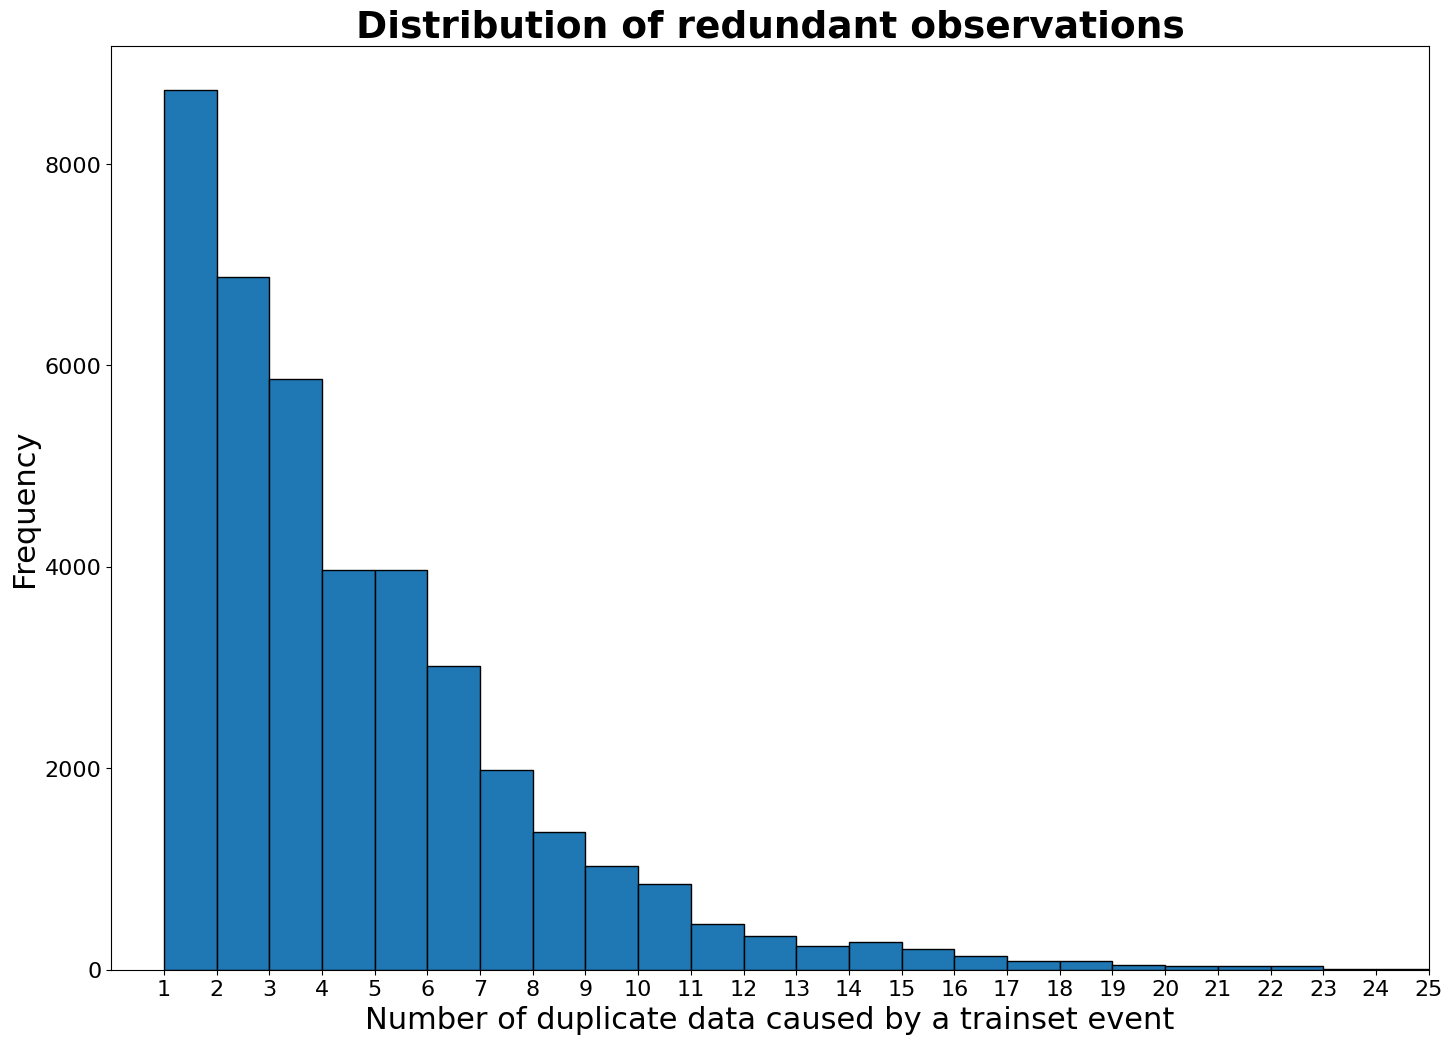

In [30]:
# EDA on duplicated obs caused by trainset observations --> how many duplicated for each timestamp?:

# 1) # Extract the sizes of each key:
sizes = [len(value) for value in trainset_duplicates.values()]
print(f"size min: {min(sizes)}")   # 1
print(f"size max: {max(sizes)}")   # 68
print("\n")

# 2) Check the sizes:
value_counts = Counter(sizes)
print(value_counts)
print("\n")
ordered_counts_desc = sorted(value_counts.items(), key=lambda item: item[0])
print("Occurrences of each value (descending order):")
for value, count in ordered_counts_desc:
    print(f"{value}: {count} times")

# 3) Plot the distribution of the sizes:
plt.figure(figsize=(17, 12))
plt.hist(sizes, bins=range(1,max(sizes)+2), edgecolor='black')
plt.title('Distribution of redundant observations', fontsize=27, fontweight='bold')
plt.xlabel('Number of duplicate data caused by a trainset event', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.yticks(fontsize=16)
plt.xticks(range(1, max(sizes) + 1), fontsize=16)
plt.xlim(0,25)

plt.savefig('distribution_plot.png', transparent=True)

'''
# 4) Find indices of size 49, 54, 107 and 142:
large_sizes = [49,54,107,142]
key_ind = []
for i in large_sizes:
    count_i = sizes.count(i)
    print(f"n. of trainsets timestamp that generates {i} duplications: {count_i}")
    indices_i = [index for index, value in enumerate(sizes) if value == i]
    print(f"The indices of the trainsets that generates {i} duplications are: {indices_i}")
    key_ind.extend(indices_i)
   
print("\n") 
print(key_ind)
print("\n")

# Find these in the dictionary and check the observations in the dataset:
pd.set_option('display.max_rows', None)
for i in key_ind:
    key = list(trainset_duplicates.keys())[i]
    print(f"Key at index {i} is: {key}")
    print(f"Obs at timestamp {key} are: {trainset_duplicates[key]}")
    print("\n")
    print("Dataset obs")
    print(df6.iloc[trainset_duplicates[key][0]:trainset_duplicates[key][-1] +1, :4])
    print("\n")
pd.reset_option('^display.', silent=True)
'''

In [31]:
# Drop from the dataset these duplicated obs caused by trainset obs:
print(f"Total number of values in the dictionary: {sum(len(v) for v in trainset_duplicates.values())}")     # 167150
print(f"Total number of obs in the dataset before the drop: {len(df6)}")                                    # 992681

obs_to_drop = [index for lists in trainset_duplicates.values() for index in lists]
print(f"Total number of obs to drop: {len(obs_to_drop)}")   # 167150

df7 = df6.drop(obs_to_drop)
print(f"Total number of obs in the dataset after the drop: {len(df7)}")     # 873135

# oss: len of df7 != len of df6-valuesdict --> why?:
# -convert obs_to_drop to a set (to not have multiple occurrences)
obs_set = set(obs_to_drop)

# -compare lengths
print("\n")
if len(obs_to_drop) != len(obs_set):
    print("Duplicate observations found in obs_to_drop")
else:
    print("No duplicate observations found in obs_to_drop")
    
# -which obs are duplicate?
element_counts = Counter(obs_to_drop)
duplicates = [element for element, count in element_counts.items() if count > 1]
print("\n")
#print(f"Duplicated values: {duplicates}")
#print("\n")
print(f"Len duplicates: {len(duplicates)}")     # =35482
print("\n")

# -check the first one:
for key, value in trainset_duplicates.items():
    if duplicates[0] in value:
        print(f"Key '{key}' has the value {duplicates[0]}")
print("\n")
print(df6.iloc[28746:28752])
print("\n")


# conclusion: due to consecutive trainset observations, same obs occur in different timestamp key in the dictionary

print(f"Len duplicated obs with 1 occurrence: {len(obs_set)}")  # =119546 --> =992681-873135 (top)

Total number of values in the dictionary: 167150
Total number of obs in the dataset before the drop: 992681
Total number of obs to drop: 167150
Total number of obs in the dataset after the drop: 873135


Duplicate observations found in obs_to_drop


Len duplicates: 35482


Key '2021-01-14 18:11:16' has the value 28748
Key '2021-01-14 18:11:17' has the value 28748


        Source     Name                Time Monitor Event_type      Type  cod  \
28746  711-084  711-083 2021-01-14 18:05:23      MS        OFF       PDM    5   
28747  711-084      NaN 2021-01-14 18:11:16      MD        OFF  TRAINSET    0   
28748  711-084      NaN 2021-01-14 18:11:17      MD        OFF  TRAINSET    0   
28749  711-083      NaN 2021-01-14 18:16:06      MS        OFF  TRAINSET    0   
28750  711-084  711-084 2021-01-14 18:16:24      MS         ON       PDO    5   
28751  711-084      NaN 2021-01-14 18:16:24      MS        OFF  TRAINSET    0   

       id  id1 Complete_code          Master  Speed Depot      L

#### Filter the dataset based on Type = PDO
#### Filter the dataset based on Event = ON
The aim of the analysis is predict and forecast when a new PDO alerts occur

In [32]:
# Filter the dataset according to "type" and "event":
df8 = df7[df7['Type'] == 'PDO']
df8.reset_index(drop=True, inplace=True)
df8 = df8[df8['Event_type'] == 'ON']
df8.reset_index(drop=True, inplace=True)
df8.info()  # length: 264068 (from 873135)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264489 entries, 0 to 264488
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Source         264489 non-null  category      
 1   Name           264489 non-null  category      
 2   Time           264489 non-null  datetime64[ns]
 3   Monitor        264489 non-null  category      
 4   Event_type     264489 non-null  category      
 5   Type           264489 non-null  category      
 6   cod            264489 non-null  int64         
 7   id             264489 non-null  int64         
 8   id1            264489 non-null  int64         
 9   Complete_code  264489 non-null  category      
 10  Master         264489 non-null  category      
 11  Speed          264489 non-null  int64         
 12  Depot          264489 non-null  category      
 13  Lat            264489 non-null  float64       
 14  Lon            264489 non-null  float64       
dtype

#### Detect and delete duplicates caused by Monitor variable
Each IDU has two monitors: MD and MS. When an alert occurs, theoretically, this appears on both the monitors. So, there is another source of duplication.

Additionally, it can happen that:
- an alert is displayed only on a single monitor
- an alert is recorded multiple times on the same monitor
- an alert is not recorded in any monitor
- there can be a different timestamp (few seconds) between the two monitors because the timestamp associated with each alert is not the timestamp of occurrence of that alert but the time of saving made by the monitor
- a monitor can have a different time than the correct one (UTC+1) because it can happen that when the system takes the greenwich time from the DIS, then it doesn't adjust the time by adding 1h --> we don't check this

By definition, it is reasonable to filter out monitor=MS but, firstly, it is necessary to solve the issues just illustrated. Therefore, an algorithm able to identify the alerts with monitor=MS that don't have the corresponding monitor=MD has been developed. Lastly, observations with monitor=MS have been discarded.

(source: "readme" file, "estratto requisiti telediagnostica" pag. 8, videocall 10/07, mail 26/06, videocall 12/07)

In [33]:
# Check Monitor values of the initial dataset and the last one (obtained by filtering and dropping duplicates):
print(df3.groupby('machine_type', dropna=False).size())
print("\n")
print(df8.groupby('Monitor', dropna=False).size())

# in both cases the ratio between MS and MD seems to be =3 more or less

machine_type
MD     414189
MS    1357959
dtype: int64


Monitor
MD     65572
MS    198917
dtype: int64


/tmp/ipykernel_2864487/3391077044.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df3.groupby('machine_type', dropna=False).size())
/tmp/ipykernel_2864487/3391077044.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df8.groupby('Monitor', dropna=False).size())


In [34]:
# Check duplicates of MS and MD before building and applying the algorithm:

#   1) MS values duplicates:
MS_df = df8[df8['Monitor'] == 'MS']
print(f"MS duplicated:")

#       a) based only on the timestamp:
MS_timestamp_counts = MS_df['Time'].value_counts()
print(MS_timestamp_counts)
print("\n")
print(f"occurrences of timestamps are:", MS_timestamp_counts.unique())
print("\n")
MS_duplicate_timestamps = MS_timestamp_counts[MS_timestamp_counts > 1].index
print(MS_duplicate_timestamps)  # length: 42203
print("\n")

#       b) based on all the columns:
MS_duplicates = MS_df.duplicated()
print(MS_duplicates.sum())  # =18201
MS_duplicated_indices = MS_df[MS_duplicates].index
print(MS_duplicated_indices)


#   2) MD values duplicates:
MD_df = df8[df8['Monitor'] == 'MD']
print("\n")
print(f"MD duplicated:")

#       a) based only on the timestamp:
MD_timestamp_counts = MD_df['Time'].value_counts()
print(MD_timestamp_counts)
print("\n")
print(f"occurrences of timestamps are:", MD_timestamp_counts.unique())
print("\n")
MD_duplicate_timestamps = MD_timestamp_counts[MD_timestamp_counts > 1].index
print(MD_duplicate_timestamps)  # length: 15018
print("\n")

#       b) based on all the columns:
MD_duplicates = MD_df.duplicated()
print(MD_duplicates.sum())  # =7669
MD_duplicated_indices = MD_df[MD_duplicates].index
print(MD_duplicated_indices)


# Drop them:
df8_a = df8.drop(MS_duplicated_indices)
df9 = df8_a.drop(MD_duplicated_indices)
df9 = df9.reset_index(drop=True)
df9.info()  # length: 238198 (from 264068)

MS duplicated:
Time
2021-02-13 06:57:26    36
2021-08-17 15:39:49    31
2021-02-13 07:01:36    30
2021-08-17 18:49:54    30
2023-08-14 20:22:17    26
                       ..
2021-08-30 11:58:13     1
2021-08-30 11:58:11     1
2021-08-30 11:58:07     1
2021-08-30 11:58:05     1
2023-09-27 21:25:50     1
Name: count, Length: 126488, dtype: int64


occurrences of timestamps are: [36 31 30 26 24 23 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4
  3  2  1]


DatetimeIndex(['2021-02-13 06:57:26', '2021-08-17 15:39:49',
               '2021-02-13 07:01:36', '2021-08-17 18:49:54',
               '2023-08-14 20:22:17', '2022-07-01 08:44:34',
               '2021-02-13 06:57:27', '2023-09-27 07:33:38',
               '2021-02-13 07:01:35', '2021-10-11 05:32:21',
               ...
               '2022-09-12 12:57:52', '2021-09-13 19:30:49',
               '2022-09-22 15:02:20', '2021-09-13 19:20:30',
               '2021-09-13 19:30:44', '2021-09-13 19:20:08',
               '2022-03-02

In [35]:
# algorithm:
#%run -i 'missing_MD_algorithm.py'

In [36]:
# Identify alerts recorded as MS without the corresponding MD record, which will be considered as MD --> develop a new variable "Monitor" which assumes value:
#   "MD" if the obs is already "MD"
#   "MS" if the obs is a duplication of the nearest "MD"
#   "MD" otherwise, which is if the obs is a new occurence of an alert

# Precisely:
#   -(we assume MS obs are correctly recorder also as MD, therefore) we seek inside MS obs the MD ones and we add them to the existing MD --> we apply the process only to increase MD obs but not also for the opposite situation (and we are also assuming that one alert appears one time in MD and one time in MS)
#   -we don't control for the misalignment, so timestamp is not used in the algorithm --> therefore we allow some duplications or mistakes during the definition of the new variable
#   -if there is an alert that occures multiple times consecutively, the algorithm is not able to recognize at all which obs is MD and MS --> therefore we allow some mistakes
#   -due to missing values in lat and lon, variable used in the algorithm are: "complete_code" and "speed"
#   -there isn't any rule which say that the order of occurrence of monitor duplication is MD-MS rather than MS-MD, but we are able to control only one sequence which will be MS-MD

MD_obs = df9[df9['Monitor'] == 'MD'].index

appoggio = 0
Real_Monitor = []
for k in range(len(MD_obs)):
	i = appoggio
	if k <= len(MD_obs) - 1:  # needed because the last obs of the dataset is an MD 
		while i <= MD_obs[k]:
			if df9.loc[i, 'Monitor'] == 'MD':
				Real_Monitor.append('MD')
			else:
				if df9.loc[i, 'Complete_code'] == df9.loc[MD_obs[k], 'Complete_code'] and df9.loc[i, 'Speed'] == df9.loc[MD_obs[k], 'Speed']:
					Real_Monitor.append('MS')
				else:
					Real_Monitor.append('MD')
			i += 1
	appoggio = i

df9['Real_Monitor'] = Real_Monitor
df9['Real_Monitor'] = df9['Real_Monitor'].astype('category')

In [37]:
# increase of MD:
Monitor_initial = df9.groupby('Monitor', dropna=False).size()
print(f"starting MD: {Monitor_initial.iloc[0]}")
Monitor_final = df9.groupby('Real_Monitor', dropna=False).size()
print(f"final MD: {Monitor_final.iloc[0]}")

increase_MD = Monitor_final.iloc[0] - Monitor_initial.iloc[0]
increase_MD_perc = (increase_MD / Monitor_initial.iloc[0]) * 100
print(f"increase of MD after applying the algorithm: {increase_MD_perc} %")

ass_MD_to_find = Monitor_initial.iloc[1] - Monitor_initial.iloc[0]
mistakes_duplications = increase_MD - ass_MD_to_find
print(f"mistakes and duplications allowed: {mistakes_duplications}")

starting MD: 57903
final MD: 214000
increase of MD after applying the algorithm: 269.5836139750963 %
mistakes and duplications allowed: 33284


/tmp/ipykernel_2864487/3964808094.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Monitor_initial = df9.groupby('Monitor', dropna=False).size()
/tmp/ipykernel_2864487/3964808094.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Monitor_final = df9.groupby('Real_Monitor', dropna=False).size()


In [38]:
# check timestamp duplicated values caused by Monitor:
Diff_time_MDMS = []
for i in range(len(df9)-1):
        if df9.loc[i, 'Real_Monitor'] == 'MD' and df9.loc[i+1, 'Real_Monitor'] == 'MS':
            diff_time = abs( df9.loc[i, 'Time'] - df9.loc[i+1, 'Time'] )
            Diff_time_MDMS.append(diff_time)

print(f"n of consecutive MD-MS: {len(Diff_time_MDMS)}")
print("\n")

print("Delta time between consecutive MD-MS:")
diff_time_counts = Counter(Diff_time_MDMS)
ordered_diff_time_counts = sorted(diff_time_counts.items())
for diff_time, count in ordered_diff_time_counts[:10]:
    print(f"{diff_time}: {count} occurrences")

n of consecutive MD-MS: 21207


Delta time between consecutive MD-MS:
0 days 00:00:00: 5403 occurrences
0 days 00:00:01: 3921 occurrences
0 days 00:00:02: 1297 occurrences
0 days 00:00:03: 812 occurrences
0 days 00:00:04: 605 occurrences
0 days 00:00:05: 427 occurrences
0 days 00:00:06: 327 occurrences
0 days 00:00:07: 289 occurrences
0 days 00:00:08: 231 occurrences
0 days 00:00:09: 180 occurrences


#### Filter the dataset based on Monitor = MD

In [39]:
df10 = df9[df9['Real_Monitor'] == 'MD']
df10.reset_index(drop=True, inplace=True)
df10 = df10.drop(columns=['Monitor'])
df10.info()   # 214000 entries
df10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214000 entries, 0 to 213999
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Source         214000 non-null  category      
 1   Name           214000 non-null  category      
 2   Time           214000 non-null  datetime64[ns]
 3   Event_type     214000 non-null  category      
 4   Type           214000 non-null  category      
 5   cod            214000 non-null  int64         
 6   id             214000 non-null  int64         
 7   id1            214000 non-null  int64         
 8   Complete_code  214000 non-null  category      
 9   Master         214000 non-null  category      
 10  Speed          214000 non-null  int64         
 11  Depot          214000 non-null  category      
 12  Lat            214000 non-null  float64       
 13  Lon            214000 non-null  float64       
 14  Real_Monitor   214000 non-null  category      
dtype

,Source,Name,Time,Event_type,Type,cod,id,id1,Complete_code,Master,Speed,Depot,Lat,Lon,Real_Monitor
0,711-083,711-083,2020-11-12 06:54:18,ON,PDO,5,5,1,5-5-1,711-083,49,0,45.4395,9.23639,MD
1,711-083,711-083,2020-11-12 06:54:18,ON,PDO,5,98,18,5-98-18,711-083,49,0,45.4395,9.23639,MD
2,711-084,711-084,2020-11-12 10:14:17,ON,PDO,2,26,1,2-26-1,Master Assente,0,0,0.0000,0.00000,MD
3,711-084,711-084,2020-11-12 10:14:17,ON,PDO,2,25,2,2-25-2,Master Assente,0,0,0.0000,0.00000,MD
4,711-084,711-084,2020-11-12 10:14:17,ON,PDO,2,25,4,2-25-4,Master Assente,0,0,0.0000,0.00000,MD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213995,711-084,710-170,2023-09-27 12:55:35,ON,PDO,5,99,13,5-99-13,711-084,15,0,45.4711,9.17230,MD
213996,711-084,710-132,2023-09-27 12:55:35,ON,PDO,5,99,13,5-99-13,711-084,15,0,45.4711,9.17230,MD
213997,711-084,711-084,2023-09-27 12:55:35,ON,PDO,5,99,13,5-99-13,711-084,15,0,45.4711,9.17230,MD
213998,711-084,711-084,2023-09-27 19:45:41,ON,PDO,5,98,10,5-98-10,711-084,0,0,45.4711,9.17231,MD


#### Latitude and longitude conversion

In order to plot the gps coordinates of each alerts inside a plot with the administrative boundaries of Italy, conversion of lat and long is needed since they are in decimal degree, while Istat coordinates (for Italy, regions, municipalities...) are in UTM format

In [40]:
# Conversion from decimal degree to UTM:
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:32632", always_xy=True)
def latlon_to_utm(lat, lon):
    utm_x, utm_y = transformer.transform(lon, lat)
    return utm_x, utm_y

df10['Lat_umt'], df10['Lon_umt'] = zip(*df10.apply(lambda row: latlon_to_utm(row['Lat'], row['Lon']), axis=1))

In [41]:
# reorder columns:
df10 = df10[["Source", "Name", "Time", "Event_type", "Type", "Real_Monitor", "cod", "id", "id1", "Complete_code", "Master", "Speed", "Depot", "Lat", "Lon", "Lat_umt", "Lon_umt"]]

df10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214000 entries, 0 to 213999
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Source         214000 non-null  category      
 1   Name           214000 non-null  category      
 2   Time           214000 non-null  datetime64[ns]
 3   Event_type     214000 non-null  category      
 4   Type           214000 non-null  category      
 5   Real_Monitor   214000 non-null  category      
 6   cod            214000 non-null  int64         
 7   id             214000 non-null  int64         
 8   id1            214000 non-null  int64         
 9   Complete_code  214000 non-null  category      
 10  Master         214000 non-null  category      
 11  Speed          214000 non-null  int64         
 12  Depot          214000 non-null  category      
 13  Lat            214000 non-null  float64       
 14  Lon            214000 non-null  float64       
 15  

#### Check duplicated values in the entire dataset

In [42]:
# are there still duplicates?:

still_dupl = df10.duplicated()
print(still_dupl.sum())  # =9066
print("\n")
still_dupl_indices = df10[still_dupl].index
print(still_dupl_indices)
print("\n")
nchesenso = df10.loc[still_dupl_indices]
print(nchesenso[:20])


# drop them:
df11 = df10.drop(still_dupl_indices)
df11 = df11.reset_index(drop=True)
print("\n")
df10.info()
df11.info()  # length: 204934 (from 214000)

9066


Index([   225,    257,    264,    265,    270,    272,    274,   1245,   1601,
         1604,
       ...
       213757, 213758, 213761, 213764, 213867, 213892, 213897, 213898, 213899,
       213900],
      dtype='int64', length=9066)


       Source     Name                Time Event_type Type Real_Monitor  cod  \
225   711-084  710-170 2020-11-13 12:32:05         ON  PDO           MD    5   
257   711-084  710-170 2020-11-13 14:03:37         ON  PDO           MD    5   
264   711-084  710-132 2020-11-13 14:33:18         ON  PDO           MD    5   
265   711-084  710-132 2020-11-13 14:33:18         ON  PDO           MD    5   
270   711-084  711-084 2020-11-13 14:40:41         ON  PDO           MD    5   
272   711-084  710-170 2020-11-13 14:40:41         ON  PDO           MD    5   
274   711-084  711-084 2020-11-13 14:40:41         ON  PDO           MD    5   
1245  711-084  711-084 2020-11-18 06:38:25         ON  PDO           MD    5   
1601  711-084  710-170 2020-11-20 08:

#### Modifying Type variable in order to correctly identify what is occurring

It is necessary to add value:
- "TRAIN_DRIVER" to correctly identify code 5-17-1
- "WARNING" to correctly identify codes 5-12-1, 5-98-11, 5-98-12

In [43]:
# make type variable categorical:
#   -PDO for every alert
#   -TRAIN_DRIVER for 5-17-1
#   -WARNING for 5-12-1, 5-98-11, 5-98-12

# check frequencies:
print(df11['Type'].value_counts())
print("\n")
print(f"How many 5-17-1?: {(df11['Complete_code'] == '5-17-1').sum()}")
print(f"How many 5-12-1?: {(df11['Complete_code'] == '5-12-1').sum()}")
print(f"How many 5-98-11?: {(df11['Complete_code'] == '5-98-11').sum()}")
print(f"How many 5-98-12?: {(df11['Complete_code'] == '5-98-12').sum()}")

# change type variable:
df11['Type'] = df11.apply(lambda row: 'TRAIN_DRIVER' if row['Complete_code'] == '5-17-1' else ('WARNING' if row['Complete_code'] in ('5-12-1','5-98-11','5-98-12') else row['Type']), axis=1)

print("\n")
print(df11['Type'].value_counts())

# back to 5-17:
df11['Complete_code'] = df11.apply(lambda row: '5-17' if row['Complete_code'] == '5-17-1' else row['Complete_code'], axis=1)
print("\n")
print(f"How many 5-17?: {(df11['Complete_code'] == '5-17').sum()}")

# "Type" and "Complete_code" are objects.... :
print("\n")
df11.info()
df11['Type'] = df11['Type'].astype('category')
df11['Complete_code'] = df11['Complete_code'].astype('category')
print("\n")
df11.info()

Type
PDO         204934
PDM              0
TRAINSET         0
Name: count, dtype: int64


How many 5-17-1?: 421
How many 5-12-1?: 91454
How many 5-98-11?: 717
How many 5-98-12?: 650


Type
PDO             111692
WARNING          92821
TRAIN_DRIVER       421
Name: count, dtype: int64


How many 5-17?: 421


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204934 entries, 0 to 204933
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Source         204934 non-null  category      
 1   Name           204934 non-null  category      
 2   Time           204934 non-null  datetime64[ns]
 3   Event_type     204934 non-null  category      
 4   Type           204934 non-null  object        
 5   Real_Monitor   204934 non-null  category      
 6   cod            204934 non-null  int64         
 7   id             204934 non-null  int64         
 8   id1            204934 non-null  int64         
 9   Comp

#### "Color" and "Criticality" derivation

There are additional information about the alerts, which are:
- colour: alerts are associated to colour "yellow" or "blue" in order to warn the train driver of the degree of risk that is occuring
- criticality: to maintainers alerts can be "critical" or "not critical" according to the degree of risk that has occured

"Codici_Diagnostici.csv" contains these details, therefore the merging of the 2 files is performed in order to link the colour and criticality to each observation

In [44]:
# check alerts group 2:
filtered_df = df11[(df11['cod'] == 2)]
#print(filtered_df)
sum_by_fullcode = filtered_df.groupby('Complete_code', dropna=False).size()
print(sum_by_fullcode)
filtered_df['Complete_code'].value_counts()

Complete_code
2-1-1     301
2-16-1     47
2-16-2    137
2-16-3    134
2-16-4    122
         ... 
5-99-5      0
5-99-6      0
5-99-7      0
5-99-8      0
5-99-9      0
Length: 300, dtype: int64


/tmp/ipykernel_2864487/2564981418.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_by_fullcode = filtered_df.groupby('Complete_code', dropna=False).size()


Complete_code
2-20-1     926
2-20-2     840
2-19-1     714
2-19-2     676
2-24-2     336
          ... 
5-32-10      0
5-32-11      0
5-32-12      0
5-32-13      0
5-99-9       0
Name: count, Length: 300, dtype: int64

In [45]:
# 1) load dataset "Codici_diagnostici"
code = pd.read_csv('..//Codici_diagnostici//Codici_Diagnostici.csv', delimiter=",")
code

,Criticality,Colour,Code
0,1,giallo,2-19
1,1,giallo,2-19-1
2,1,giallo,2-19-2
3,1,giallo,5-1
4,1,giallo,5-1-1
...,...,...,...
243,0,azzurro,5-99-12
244,0,azzurro,5-99-13
245,0,azzurro,5-99-14
246,0,azzurro,5-20


In [46]:
# 2) merge:
datasetcomplete = pd.merge(df11, code, left_on='Complete_code', right_on='Code')
datasetcomplete = datasetcomplete.drop(columns=['Code'])
datasetcomplete     # length: 193901 --> not 204934 because there are additional alerts of group 2 in the log data than the 2-19-1 and 2-19-2, therefore when the merge is performed all the others alerts are deleted

,Source,Name,Time,Event_type,Type,Real_Monitor,cod,id,id1,Complete_code,Master,Speed,Depot,Lat,Lon,Lat_umt,Lon_umt,Criticality,Colour
0,711-083,711-083,2020-11-12 06:54:18,ON,PDO,MD,5,5,1,5-5-1,711-083,49,0,45.4395,9.23639,518488.162378,5.031802e+06,0,giallo
1,711-083,711-083,2020-11-12 06:54:18,ON,PDO,MD,5,98,18,5-98-18,711-083,49,0,45.4395,9.23639,518488.162378,5.031802e+06,0,azzurro
2,711-084,710-132,2020-11-12 10:50:09,ON,PDO,MD,5,98,14,5-98-14,711-084,0,0,45.5789,9.15668,512223.798419,5.047274e+06,0,azzurro
3,711-084,710-170,2020-11-12 10:57:17,ON,PDO,MD,5,11,1,5-11-1,711-084,61,0,45.5578,9.16639,512986.210566,5.044931e+06,0,giallo
4,711-084,710-170,2020-11-12 10:57:17,ON,PDO,MD,5,11,3,5-11-3,711-084,61,0,45.5578,9.16639,512986.210566,5.044931e+06,0,giallo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193896,711-084,710-170,2023-09-27 12:55:35,ON,PDO,MD,5,99,13,5-99-13,711-084,15,0,45.4711,9.17230,513468.132303,5.035300e+06,0,azzurro
193897,711-084,710-132,2023-09-27 12:55:35,ON,PDO,MD,5,99,13,5-99-13,711-084,15,0,45.4711,9.17230,513468.132303,5.035300e+06,0,azzurro
193898,711-084,711-084,2023-09-27 12:55:35,ON,PDO,MD,5,99,13,5-99-13,711-084,15,0,45.4711,9.17230,513468.132303,5.035300e+06,0,azzurro
193899,711-084,711-084,2023-09-27 19:45:41,ON,PDO,MD,5,98,10,5-98-10,711-084,0,0,45.4711,9.17231,513468.913971,5.035300e+06,0,azzurro


In [47]:
# check alerts group 2:
filtered_df = datasetcomplete[(datasetcomplete['cod'] == 2)]
sum_by_fullcode = filtered_df.groupby('Complete_code', dropna=False).size()
sum_by_fullcode

Complete_code
2-19-1    714
2-19-2    676
dtype: int64

In [48]:
# Final dataset:
#   a) csv file:
df040_final = copy_df(datasetcomplete)
df040_final.to_csv(path_final+'//'+input_file[:-4]+'_cleaned.csv', index=False)

#   b) parquet file to preserve dtypes:
df040_final.to_parquet(path_final+'//'+input_file[:-4]+'_cleaned.parquet', engine='fastparquet')